<div style="display: flex; background-color: #3F579F;">
    <h1 style="margin: auto; font-weight: bold; padding: 30px 30px 0px 30px; color:#fff;" align="center">Implement a scoring model - P7</h1>
</div>
<div style="display: flex; background-color: #3F579F; margin: auto; padding: 5px 30px 0px 30px;" >
    <h3 style="width: 100%; text-align: center; float: left; font-size: 24px; color:#fff;" align="center">| Notebook optimization |</h3>
</div>
<div style="display: flex; background-color: #3F579F; margin: auto; padding: 10px 30px 30px 30px;">
    <h4 style="width: 100%; text-align: center; float: left; font-size: 24px; color:#fff;" align="center">Data Scientist course - OpenClassrooms</h4>
</div>

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">1. Libraries and files</h2>
</div>

<div style="background-color: #506AB9;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">1.1. Libraries</h3>
</div>

In [1]:
import re
import numpy as np
import pandas as pd

from imblearn.over_sampling import SMOTE

import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler

## Own specific functions 
from functions import *

<div style="background-color: #506AB9;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">1.2. Files</h3>
</div>

In [2]:
df = pd.read_csv(r"datasets\df_processed.csv", nrows=10000)
#df = pd.read_csv(r"datasets\df_processed.csv")
df = df.drop(columns=["index"])

In [3]:
df_analysis(df, "df", analysis_type="header")


Analysis Header of df dataset
--------------------------------------------------------------------------------
- Dataset shape:			 10000 rows and 797 columns
- Total of NaN values:			 2058717
- Percentage of NaN:			 25.83 %
- Total of infinite values:		 1
- Percentage of infinite values:	 0.0 %
- Total of full duplicates rows:	 0
- Total of empty rows:			 0
- Total of empty columns:		 0
- Unique indexes:			 True
- Memory usage:				 60.8 MB


<div class="alert alert-block alert-warning">
    <p><b>Observations / Conclusions</b></p>
    <ul style="list-style-type: square;">
        <li><b>Missing values</b> - There are 25.39% of missing-values to treat</li>
        <li><b>Infinite values</b> - There are 25 infinite values</li>
    </ul> 
</div>

<div style="background-color: #506AB9;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">1.2.1 Optimizing memory usage</h4>
</div>

<div class="alert alert-block alert-info">
    <p>We should optimize the memory usage to avoid problems during executions</p>
</div>

In [4]:
df["TARGET"].fillna(value=-99, inplace=True)
df["TARGET"] = df["TARGET"].astype("int8")
df["TARGET"] = df["TARGET"].replace(-99, np.nan)

In [5]:
for col in df.columns:
    if df[col].dtype == "int64" and df[col].nunique() == 2:
        df[col] = df[col].astype("int8")

In [6]:
for col in df.columns:
    if df[col].dtype == "float64" and df[col].min() >= -2147483648 and df[col].max() <= 2147483648:
        df[col] = df[col].astype("float32")

In [7]:
df_analysis(df, "df", analysis_type="header")


Analysis Header of df dataset
--------------------------------------------------------------------------------
- Dataset shape:			 10000 rows and 797 columns
- Total of NaN values:			 2058717
- Percentage of NaN:			 25.83 %
- Total of infinite values:		 1
- Percentage of infinite values:	 0.0 %
- Total of full duplicates rows:	 0
- Total of empty rows:			 0
- Total of empty columns:		 0
- Unique indexes:			 True
- Memory usage:				 26.9 MB


In [8]:
df.head()

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,100002,1,0,0,0,0,202500.0,406597.5,24700.5,351000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100003,0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100004,0,0,1,0,0,67500.0,135000.0,6750.0,135000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,0,1,0,0,0,135000.0,312682.5,29686.5,297000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
4,100007,0,0,0,0,0,121500.0,513000.0,21865.5,513000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
df.select_dtypes(include=["object"]).columns.tolist()

[]

<div class="alert alert-block alert-warning">
    <p><b>Observations / Conclusions</b></p>
    <ul style="list-style-type: square;">
        <li><b>Columns type</b> - All columns are numerics</li>
    </ul> 
</div>

<div style="background-color: #506AB9;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">1.2.2. Missing-values</h4>
</div>

<div class="alert alert-block alert-info">
    <p>Before treating the class imbalance in the target, it is necessary to treat the missing-values in all the dataset, to do that, we are going to fill values with SimpleImputer
   </p>
    <p>Let's start by identifying the features with infinite-values and replace them by missing-values
   </p>
</div>
</div>

In [10]:
inf_cols = df.columns.to_series()[np.isinf(df).any()]

In [11]:
for col in inf_cols:
    df[col] = df[col].replace([np.inf, -np.inf], np.nan)

In [12]:
df_analysis(df, "df", analysis_type="header")


Analysis Header of df dataset
--------------------------------------------------------------------------------
- Dataset shape:			 10000 rows and 797 columns
- Total of NaN values:			 2058718
- Percentage of NaN:			 25.83 %
- Total of infinite values:		 0
- Percentage of infinite values:	 0.0 %
- Total of full duplicates rows:	 0
- Total of empty rows:			 0
- Total of empty columns:		 0
- Unique indexes:			 True
- Memory usage:				 26.9 MB


<div class="alert alert-block alert-info">
    <p>Let's continue by identifying the features with missingv-values and excluding the TARGET
   </p>
</div>
</div>

In [13]:
nan_cols = [i for i in df.columns if i!="TARGET" and df[i].isnull().any()]

In [14]:
for col in nan_cols:
    mean_value = df[col].mean()
    df[col].fillna(value=mean_value, inplace=True)

In [15]:
df_analysis(df, "df", analysis_type="header")


Analysis Header of df dataset
--------------------------------------------------------------------------------
- Dataset shape:			 10000 rows and 797 columns
- Total of NaN values:			 0
- Percentage of NaN:			 0.0 %
- Total of infinite values:		 0
- Percentage of infinite values:	 0.0 %
- Total of full duplicates rows:	 0
- Total of empty rows:			 0
- Total of empty columns:		 0
- Unique indexes:			 True
- Memory usage:				 26.9 MB


<div class="alert alert-block alert-success">
    <p>At this point, TARGET is the only column with missing-values</p>
</div>

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">2. Class Imbalance</h2>
</div>

<div style="background-color: #506AB9;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">2.1. Verifying</h3>
</div>

<div class="alert alert-block alert-info">
    <p>Now, we are going to analyze in details, whether ours target has an imbalanced class
   </p>
</div>

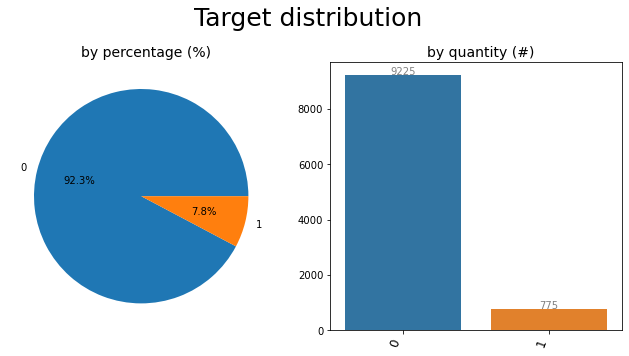

In [16]:
barplot_and_pie(df["TARGET"], "Target distribution", " ")

<div class="alert alert-block alert-warning">
    <p>Here we can see how much the dataset is imbalanced</p>
</div>

<div style="background-color: #506AB9;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">2.2. Smote</h3>
</div>

<div class="alert alert-block alert-info">
    <p>To treat the Imbalanced class, we are going to use a type of data augmentation for the minority class (Oversampling) where new examples can be synthesized from the existing examples and it is referred as the Synthetic Minority Oversampling Technique - SMOTE.</p>
</div>

In [17]:
train_df = df[df["TARGET"].notnull()]
test_df = df[df["TARGET"].isnull()]

In [18]:
X = train_df.drop(columns=["TARGET"])

In [19]:
y = train_df.loc[:,"TARGET"]

<div class="alert alert-block alert-info">
    <p>Freeing up memory </p>
</div>

In [20]:
#del df
#gc.collect()

<div class="alert alert-block alert-info">
    <p>Initializing SMOTE</p>
</div>

In [21]:
smote = SMOTE(sampling_strategy="auto", k_neighbors=5, n_jobs=-1,
              random_state=42)

<div class="alert alert-block alert-info">
    <p>Executing SMOTE</p>
</div>

In [22]:
X_resampled, y_resampled = smote.fit_resample(X, y)

<div class="alert alert-block alert-info">
    <p>Finally, we can see the results</p>
</div>

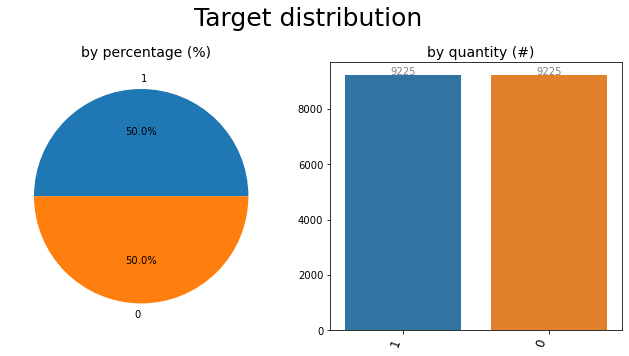

In [23]:
barplot_and_pie(y_resampled, "Target distribution", " ")

<div class="alert alert-block alert-success">
    <p>Now, we have the Target balanced</p>
</div>

<div style="background-color: #506AB9;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">2.4. Rebuild the dataset</h3>
</div>

<div class="alert alert-block alert-info">
    <p>Creating series with attributes</p>
</div>

In [24]:
y_resampled  = pd.Series(y_resampled, name="TARGET")

<div class="alert alert-block alert-info">
    <p>Merging result dataset with result series</p>
</div>

In [25]:
df_resampled = X_resampled.merge(y_resampled, left_index=True, right_index=True)
#X_resampled.insert(loc=1 column="TARGET", value=y_resampled)

<div class="alert alert-block alert-info">
    <p>Freeing up memory </p>
</div>

In [26]:
del X_resampled
gc.collect()

9880

In [27]:
del y_resampled
gc.collect()

0

<div class="alert alert-block alert-info">
    <p>Concatenating the dataset</p>
</div>

In [28]:
df_resampled = pd.concat([df_resampled, test_df])

<div class="alert alert-block alert-info">
    <p>Freeing up memory </p>
</div>

In [29]:
del test_df
gc.collect()

0

<div class="alert alert-block alert-info">
    <p>Let's see the final dataset</p>
</div>

In [30]:
df_analysis(df_resampled, "df_resampled", analysis_type="header")


Analysis Header of df_resampled dataset
--------------------------------------------------------------------------------
- Dataset shape:			 18450 rows and 797 columns
- Total of NaN values:			 0
- Percentage of NaN:			 0.0 %
- Total of infinite values:		 0
- Percentage of infinite values:	 0.0 %
- Total of full duplicates rows:	 0
- Total of empty rows:			 0
- Total of empty columns:		 0
- Unique indexes:			 True
- Memory usage:				 49.8 MB


<div class="alert alert-block alert-success">
    <p><b>Observations / Conclusions</b></p>
    <p>At this point we have two datasets. The first one called <b>df</b> that is imbalanced. And the second one <b>df_resample</b> that is balanced after treating it through SMOTE</p> 
</div>

In [31]:
xx

NameError: name 'xx' is not defined

<div class="alert alert-block alert-danger">
    <h2>FLAG</h2>
</div>

In [32]:
from hyperopt import tpe, hp, fmin, STATUS_OK, Trials, space_eval
from hyperopt.pyll.base import scope
#import warnings

#warnings.filterwarnings("ignore")

In [33]:
space_params = {
    "n_estimators" : hp.choice("n_estimators", np.arange(5000, 10000, 15000)),
    "learning_rate" :  hp.uniform("learning_rate", 0.002, 0.003),
    "num_leaves" :  hp.choice("num_leaves", np.arange(30, 34, 38)),
    "colsample_bytree" : hp.uniform("colsample_bytree", 0.9497036, 1.0497036),
    "subsample" : hp.uniform("subsample",0.8715623, 0.9715623),
    "max_depth" : hp.choice("max_depth", range(7, 8, 9)),
    "reg_alpha" : hp.uniform("reg_alpha", 0.041545473, 0.051),
    "reg_lambda" : hp.uniform("reg_lambda", 0.0735294, 0.0835294),
    "min_split_gain" : hp.uniform("min_split_gain", 0.0222415, 0.0322415),
    "min_child_weight" : hp.uniform("min_child_weight", 39.3259775, 49)
}

In [34]:
def hyperparameter_tuning(space_params, df=df, n_splits=10):
    
    # Formatting columns name
    df = df.rename(columns=lambda x:re.sub("[^A-Za-z0-9_]+", "", x))
    df_lgbm = df.copy()
    
    scaler = StandardScaler()
    
    # Divide in training/validation and test data
    train_df = df_lgbm[df_lgbm["TARGET"].notnull()]
    test_df = df_lgbm[df_lgbm["TARGET"].isnull()]
    del df_lgbm
    gc.collect()
    
    # Cross validation model
    folds = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feats = [f for f in train_df.columns if f not in ["TARGET", "SK_ID_CURR", "SK_ID_BUREAU", "SK_ID_PREV"]]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df["TARGET"])):
        
        print("\n")
        
        train_x, train_y = train_df[feats].iloc[train_idx], train_df["TARGET"].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df["TARGET"].iloc[valid_idx]
    
        train_x_scaled = scaler.fit_transform(train_x)
        valid_x_scaled = scaler.fit_transform(valid_x)
        
        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            **space_params,
            is_unbalance=True,
            n_jobs=-1 
        )
        
        evaluation = [(train_x_scaled, train_y), (valid_x_scaled, valid_y)]
        
        clf.fit(train_x_scaled, train_y, eval_set=evaluation, eval_metric="auc",
                callbacks=[lgb.early_stopping(stopping_rounds=200),
                          lgb.log_evaluation(period=-1)])
        
        #oof_preds[valid_idx] = clf.predict(valid_x_scaled)
        #y_score = clf.predict_proba(valid_x_scaled, num_iteration=clf.best_iteration_)[:, 1]
        
        
        
        oof_preds[valid_idx] = clf.predict_proba(valid_x_scaled, num_iteration=clf.best_iteration_)[:, 1]
        
        print("Fold %2d AUC : %.6f" % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_x_scaled, train_y, valid_x, valid_x_scaled, valid_y
        gc.collect()
        
    print("\n")
    auc = roc_auc_score(train_df["TARGET"], oof_preds)
    print(">> ROC-AUC Score %.6f" % auc)        
        
    return { "loss": -auc, "status": STATUS_OK } 

In [35]:
# Initialize trials object
trials = Trials()

best = fmin(
    fn=hyperparameter_tuning,
    space=space_params, 
    algo=tpe.suggest, 
    max_evals=100, 
    trials=trials
)

Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:                     
[55]	training's auc: 0.847637	training's binary_logloss: 0.259356	valid_1's auc: 0.744704	valid_1's binary_logloss: 0.298497
Fold  1 AUC : 0.744704                                 
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:                     
[52]	training's auc: 0.846464	training's binary_logloss: 0.261458	valid_1's auc: 0.78225	valid_1's binary_logloss: 0.280519
Fold  2 AUC : 0.782250                                 
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:                     
[19]	training's auc: 0.818684	training's binary_logloss: 0.267596	valid_1's auc: 0.765975	valid_1's binary_logloss: 0.250818
Fold  3 AUC : 0.765975                                 
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:        

job exception: Check failed: (feature_fraction) <= (1.0) at d:\bld\lightgbm_1637422798668\work\compile\src\io\config_auto.cpp, line 373 .




  1%|          | 1/100 [01:02<1:43:53, 62.97s/trial, best loss: -0.6976516129032259]


LightGBMError: Check failed: (feature_fraction) <= (1.0) at d:\bld\lightgbm_1637422798668\work\compile\src\io\config_auto.cpp, line 373 .


In [ ]:
print("Best: {}".format(best))

<div class="alert alert-block alert-danger">
    <h2>FLAG</h2>
</div>

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">3. Model Optimization</h2>
</div>

<div class="alert alert-block alert-info">
    <p>Now</p>
</div>

<div class="alert alert-block alert-danger">
    <h2>FLAG</h2>
</div>

In [ ]:
def kfold_lightgbm(df, n_splits):
    
    # Formatting columns name
    df = df.rename(columns=lambda x:re.sub("[^A-Za-z0-9_]+", "", x))
    
    scaler = StandardScaler()
    
    # Divide in training/validation and test data
    train_df = df[df["TARGET"].notnull()]
    test_df = df[df["TARGET"].isnull()]
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    
    # Cross validation model
    folds = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ["TARGET", "SK_ID_CURR", "SK_ID_BUREAU", "SK_ID_PREV"]]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df["TARGET"])):
        
        print("\n")
        
        train_x, train_y = train_df[feats].iloc[train_idx], train_df["TARGET"].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df["TARGET"].iloc[valid_idx]
        
    
        train_x_scaled = scaler.fit_transform(train_x)
        valid_x_scaled = scaler.fit_transform(valid_x)
        
        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            
            #class_weight="balanced",
            is_unbalance=True,
            #nthread=4,
            n_jobs=-1,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            #silent=-1,
            #verbose=-1, 
        )
        
        clf.fit(train_x_scaled, train_y, eval_set=[(train_x_scaled, train_y), (valid_x_scaled, valid_y)],
                eval_metric= 'auc',
                callbacks=[lgb.early_stopping(stopping_rounds=200),
                          lgb.log_evaluation(period=-1)])
        
        oof_preds[valid_idx] = clf.predict_proba(valid_x_scaled, num_iteration=clf.best_iteration_)[:, 1]
        
        if test_df[feats].shape[0] > 0:
            sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_x_scaled, train_y, valid_x, valid_x_scaled, valid_y
        gc.collect()
        
    print("\n")
    print('>> Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
        
        
        
        

kfold_lightgbm(df, n_splits=10)     
        
        

In [ ]:
xx

In [ ]:
#kfold_lightgbm(df, n_splits=10)

In [ ]:
# LightGBM GBDT with KFold or Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
def kfold_lightgbm(df, num_folds, stratified=False, debug=False):
    
    df = df.rename(columns=lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    
    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
        
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        
        print("\n")
        
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            
            class_weight="balanced",
            
            #nthread=4,
            n_jobs=-1,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            #silent=-1,
            #verbose=-1, 
        )

        #clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)],
        #        eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)
        
        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)],
                eval_metric= 'auc',
                callbacks=[lgb.early_stopping(stopping_rounds=200),
                          lgb.log_evaluation(period=-1)])
        
        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()
        
    print("\n")
    print('>> Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    
    # Write submission file and plot feature importance
    if not debug:
        test_df['TARGET'] = sub_preds
        test_df[['SK_ID_CURR', 'TARGET']].to_csv("datasets\submission_kernel02.csv", index=False)
        
    #display_importances(feature_importance_df)
    
    return feature_importance_df

<div class="alert alert-block alert-danger">
    <h2>FLAG</h2>
</div>

In [ ]:
xxx

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">3. Initial Model</h2>
</div>

<div style="background-color: #506AB9;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">3.1. LGBMClassifier model</h3>
</div>

In [ ]:
# LightGBM GBDT with KFold or Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
def kfold_lightgbm(df, num_folds, stratified=False, debug=False):
    
    df = df.rename(columns=lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    
    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
        
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        
        print("\n")
        
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            
            class_weight="balanced",
            
            #nthread=4,
            n_jobs=-1,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            #silent=-1,
            #verbose=-1, 
        )

        #clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)],
        #        eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)
        
        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)],
                eval_metric= 'auc',
                callbacks=[lgb.early_stopping(stopping_rounds=200),
                          lgb.log_evaluation(period=-1)])
        
        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()
        
    print("\n")
    print('>> Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    
    # Write submission file and plot feature importance
    if not debug:
        test_df['TARGET'] = sub_preds
        test_df[['SK_ID_CURR', 'TARGET']].to_csv("datasets\submission_kernel02.csv", index=False)
        
    #display_importances(feature_importance_df)
    
    return feature_importance_df

In [ ]:
feat_importance = kfold_lightgbm(df, num_folds=10, stratified=False, debug=False)